In [1]:
import os
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from torch._C import device
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.autograd.grad_mode import F
from numpy.core.defchararray import join,mod
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as torchtrans
from torchvision.models.detection import FasterRCNN
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [2]:
class HarmfulObjectDataset(Dataset):
    def __init__(self, imgs_path, labels_path, transforms=None):
        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.transforms = transforms
        
        self.img_names = [img for img in sorted(os.listdir(self.imgs_path)) if img.endswith(('.jpg', '.png', '.jpeg'))]
        self.label_names = [label for label in sorted(os.listdir(self.labels_path)) if label.endswith('.txt')]
        
        self.img_names = [img for img in self.img_names if self._get_label_file(img)]

    def _get_label_file(self, img_name):
        base_name = img_name.rsplit('.', 1)[0]
        label_file = f"{base_name}.txt"
        return label_file if label_file in self.label_names else None

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.imgs_path, img_name)
        label_file = self._get_label_file(img_name)
        label_path = os.path.join(self.labels_path, label_file)
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_rgb /= 255.0
        
        if self.transforms:
            img_rgb = self.transforms(img_rgb)
        
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            label = int(line[0])
            x_center, y_center, width, height = map(float, line[1:])
        
        img_height, img_width = img_rgb.shape[1], img_rgb.shape[2]
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height

        # Ensure boxes have positive width and height
        if x_min >= x_max or y_min >= y_max:
            raise ValueError(f"Invalid bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")
        
        boxes = torch.as_tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        return img_rgb, target

In [3]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))


In [4]:
def train_model(model, data_loader, device, num_epochs=20, lr=0.005):
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        lr_scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return model

In [5]:
def make_predictions(model, dataset, device, idx=0):
    model.eval()
    img, _ = dataset[idx]
    img = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img)
    
    return prediction[0]

In [6]:
def plot_prediction(image, prediction, threshold=0.5):
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    img_np = np.array(image)
    
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)
    
    for i, (box, score) in enumerate(zip(boxes, scores)):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 edgecolor='r', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'{score:.2f}', color='white', fontsize=12, backgroundcolor='black')
    
    plt.show()

In [7]:
imgs_path = '/kaggle/input/harmful-object-detection/Harmful Object Detection/Images'
labels_path = '/kaggle/input/harmful-object-detection/Harmful Object Detection/Labels'

transforms = T.Compose([T.ToTensor()])
dataset = HarmfulObjectDataset(imgs_path, labels_path, transforms=transforms)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_classes = 5
model = get_model(num_classes)
model = train_model(model, data_loader, device, num_epochs=10)

torch.save(model.state_dict(), 'harmful_object_detector.pth')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 229MB/s]


Epoch 1/10, Loss: 78.2794
Epoch 2/10, Loss: 51.7392
Epoch 3/10, Loss: 42.2987
Epoch 4/10, Loss: 31.8566
Epoch 5/10, Loss: 29.3850
Epoch 6/10, Loss: 27.4597
Epoch 7/10, Loss: 26.0338
Epoch 8/10, Loss: 25.7586
Epoch 9/10, Loss: 25.4445
Epoch 10/10, Loss: 25.1735


/tmp/ipykernel_23/674948823.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('harmful_object_detector.pth'))


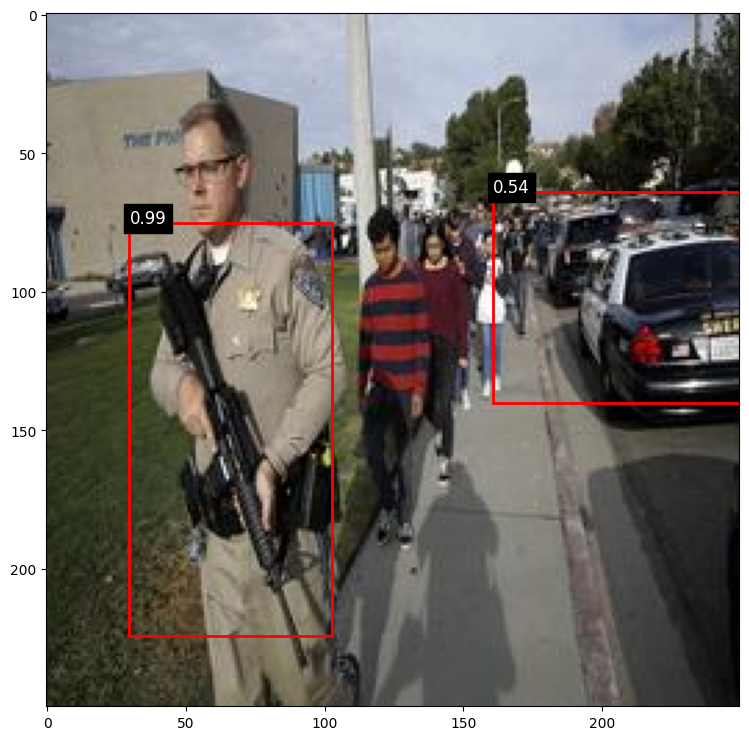

In [8]:
model.load_state_dict(torch.load('harmful_object_detector.pth'))
model.to(device)

prediction = make_predictions(model, dataset, device, idx=10)
plot_prediction(dataset[10][0].permute(1, 2, 0).numpy(), prediction)

In [9]:
import numpy as np
import torch
from torchvision.ops import box_iou
from sklearn.metrics import average_precision_score

def compute_metrics(predictions, targets, num_classes, iou_thresh=0.5):
    all_true_boxes = {i: [] for i in range(num_classes)}
    all_pred_boxes = {i: [] for i in range(num_classes)}
    all_pred_scores = {i: [] for i in range(num_classes)}
    
    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        
        true_boxes = target['boxes'].cpu().numpy()
        true_labels = target['labels'].cpu().numpy()
        
        for label in np.unique(true_labels):
            class_true_boxes = true_boxes[true_labels == label]
            class_pred_boxes = pred_boxes[pred_labels == label]
            class_pred_scores = pred_scores[pred_labels == label]
            
            all_true_boxes[label].extend(class_true_boxes)
            all_pred_boxes[label].extend(class_pred_boxes)
            all_pred_scores[label].extend(class_pred_scores)
    
    avg_precisions = []
    for i in range(num_classes):
        if len(all_true_boxes[i]) == 0:
            continue
        
        pred_boxes = np.array(all_pred_boxes[i])
        pred_scores = np.array(all_pred_scores[i])
        true_boxes = np.array(all_true_boxes[i])
        
        if len(pred_boxes) == 0 or len(true_boxes) == 0:
            continue
        
        pred_boxes_tensor = torch.tensor(pred_boxes, dtype=torch.float32)
        true_boxes_tensor = torch.tensor(true_boxes, dtype=torch.float32)
        
        # Compute IoU
        iou = box_iou(pred_boxes_tensor, true_boxes_tensor)
        max_iou, _ = iou.max(dim=1)
        
        # Compute precision and recall
        tp = (max_iou > iou_thresh).float()
        fp = (max_iou <= iou_thresh).float()
        
        # Calculate Average Precision
        if len(pred_scores) > 0:
            avg_precision = average_precision_score(
                (max_iou > iou_thresh).cpu().numpy(), pred_scores
            )
            avg_precisions.append(avg_precision)
        else:
            avg_precisions.append(0.0)
    
    mean_avg_precision = np.mean(avg_precisions) if avg_precisions else 0.0
    
    return {
        'mean_average_precision': mean_avg_precision
    }


In [10]:
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for imgs, target_list in data_loader:
            imgs = [img.to(device) for img in imgs]
            targets.extend(target_list)
            outputs = model(imgs)
            predictions.extend(outputs)
    
    num_classes = 5  # Update this to the number of classes in your dataset
    metrics = compute_metrics(predictions, targets, num_classes)
    return metrics

In [11]:
imgs_path = '/kaggle/input/harmful-object-detection/Harmful Object Detection/Images'
labels_path = '/kaggle/input/harmful-object-detection/Harmful Object Detection/Labels'

transforms = T.Compose([T.ToTensor()])
dataset = HarmfulObjectDataset(imgs_path, labels_path, transforms=transforms)
data_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_classes = 5
model = get_model(num_classes)
model.load_state_dict(torch.load('harmful_object_detector.pth'))
model.to(device)

metrics = evaluate_model(model, data_loader, device)
print("Evaluation Metrics:")
print(f"Mean Average Precision: {metrics['mean_average_precision']:.4f}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_23/3062612165.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrust

Evaluation Metrics:
Mean Average Precision: 0.9862
